# Advanced RAG - Handling Additional Problems
* Notebook by Adam Lang
* Date: 10/12/24

# How to handle Advanced RAG Problems
* In this notebook we will cover how to handle the following RAG issues:
1. Missed Top Ranked
2. Not in Context
3. Not Extracted
4. Incorrect Specificity
5. Wrong Format

# Techniques we will cover for Advanced RAG for the Top 4 problems above
1. Effect of Embedding models
2. Advanced Retrieval Strategies
3. Chained Retrieval with Rerankers
4. Contextual Compression Strategies

# Techniques we will cover for Advanced RAG for the "Wrong Format" Problem
1. Native LLM Supporet
2. Output Parsers



## Install Dependencies

In [1]:
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install langchain-huggingface
!pip install langchain-chroma # vector DB
!pip install rank_bm25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/

## Enter Tokens for OpenAI, HuggingFace

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter your OPEN AI API Key: ')

Enter your OPEN AI API Key: ··········


In [3]:
from getpass import getpass

HUGGINGFACEHUB_API_TOKEN = getpass('Enter HuggingFace Token key: ')

Enter HuggingFace Token key: ··········


In [4]:
## setup operation sys env
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['HUGGINGFACEHUB_API_TOKEN'] = HUGGINGFACEHUB_API_TOKEN

# Get a Dataset from Wikipedia

In [5]:
!gdown 1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW

Downloading...
From (original): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW
From (redirected): https://drive.google.com/uc?id=1oWBnoxBZ1Mpeond8XDUSO6J9oAjcRDyW&confirm=t&uuid=7235c166-b070-44d4-93bf-febb73374045
To: /content/simplewiki-2020-11-01.jsonl.gz
100% 50.2M/50.2M [00:02<00:00, 22.4MB/s]


In [6]:
## imports to load dataset
import gzip
import json
from langchain.docstore.document import Document


## wikipedia filepath
wikipedia_filepath = '/content/simplewiki-2020-11-01.jsonl.gz'


## store docs in list
docs = []
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as fIn:
  for line in fIn:
    data = json.loads(line.strip()) #whitespace strip
    #only add 1st paragraph
    docs.append({
                    'metadata': {
                                  'title': data.get('title'),
                                  'article_id': data.get('id')
                    },
                    'data': data.get('paragraphs')[0] #restrict data to first 3 paragraphs

    })

In [7]:
## filter out docs only related to a specific topic
docs = [doc for doc in docs for x in ['india']
          if x in doc['data'].lower().split()]

docs = [Document(page_content=doc['data'],
                 metadata=doc['metadata']) for doc in docs]


# get len of docs
len(docs)

767

In [8]:
## lets see first 3 docs
docs[:3]

[Document(metadata={'title': 'Basil', 'article_id': '73985'}, page_content='Basil ("Ocimum basilicum") ( or ) is a plant of the Family Lamiaceae. It is also known as Sweet Basil or Tulsi. It is a tender low-growing herb that is grown as a perennial in warm, tropical climates. Basil is originally native to India and other tropical regions of Asia. It has been cultivated there for more than 5,000 years. It is prominently featured in many cuisines throughout the world. Some of them are Italian, Thai, Vietnamese and Laotian cuisines. It grows to between 30–60\xa0cm tall. It has light green, silky leaves 3–5\xa0cm long and 1–3\xa0cm broad. The leaves are opposite each other. The flowers are quite big. They are white in color and arranged as a spike.'),
 Document(metadata={'title': 'Roerich’s Pact', 'article_id': '259745'}, page_content='The Roerich Pact is a treaty on Protection of Artistic and Scientific Institutions and Historic Monuments, signed by the representatives of 21 states in the

# Exploring Different Embedding Models

## 1. Hugging Face - SBERT model
* This is an older model: https://huggingface.co/sentence-transformers/multi-qa-MiniLM-L6-cos-v1

In [9]:
## HF embeddings
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

## embed model
model_name = 'sentence-transformers/multi-qa-MiniLM-L6-cos-v1'

## load model
sbert_embedder = HuggingFaceEmbeddings(model_name=model_name)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Create Vector Store in Chroma DB

In [10]:
## load chroma
from langchain_chroma import Chroma

# create vector DB for docs + embedddings
chroma_db1 = Chroma.from_documents(documents=docs,
                                   collection_name='wikipedia_db1',
                                   embedding=sbert_embedder,
                                   collection_metadata={"hnsw:space": "cosine"}) ## have to set this to cosine as default is euclidean

# setup retriever1 --> get top 2 similar docs
retriever1 = chroma_db1.as_retriever(search_type='similarity',
                                     search_kwargs={"k": 2})


# query
query = "What is the capital of India?"
#retrieve top docs
top_docs = retriever1.invoke(query)
top_docs

[Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once the center of industry and education. However, it has witnessed political violence and economic problems since 1954. Since 2000, Kolkata has grown due to economic growth. Like other metropolitan cities in India, Kolkata struggles with poverty, pollution and traffic congestion."),
 Document(metadata={'article_id': '352194', 'title': 'Gandhinagar'}, page_content='Gandhinagar is the capital city of Gujarat state in India. It is 23\xa

Summary:
* We can see the top 2 doc were NOT the most relevant documents.
* The capital of india is New Delhi, so obviously these 2 top docs are not correct.

In [11]:
## lets try another query
query = "What is the old capital of India?"
## get top docs
top_docs = retriever1.invoke(query)
top_docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '352194', 'title': 'Gandhinagar'}, page_content='Gandhinagar is the capital city of Gujarat state in India. It is 23\xa0km from the city of Ahmedabad and 464\xa0km from Mumbai. In the year 1960, the Bombay state of India was divided into two states - Maharashtra and Gujarat. Bombay (now called Mumbai) became the capital city of Maharashtra. For Gujarat, new capital was needed. Gandhinagar was then made the capital of Gujarat.')]

Summary:
* Here the 1st hit is New Delhi, but the 2nd document should be Kolkata which is the old capital of India. So it appears content is missing.
* New Delhi is not the actual old capital of India that is Kolkata so the top 2 docs were not correct either here.
* What do we do?

### Try another embedding model from HuggingFace
* Here we will try a newer embeddding model from mixedbread.ai which has different dimensions than the previous model used.
* mixed bread large: https://huggingface.co/mixedbread-ai/mxbai-embed-large-v1
* The dimensions on this model are 512.
* This model also performs well on the MTEB benchmarks.

In [12]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

## load model from HF hub
model_name = 'mixedbread-ai/mxbai-embed-large-v1'

## init embedding model
mxbai_embedder = HuggingFaceEmbeddings(model_name=model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Create Vector Store in Chroma DB

In [13]:
## 2nd chroma vector store
chroma_db2 = Chroma.from_documents(documents=docs,
                                   collection_name='wikipedia_db2',
                                   embedding=mxbai_embedder,
                                   collection_metadata={'hnsw:space': 'cosine'})


## init retriever2
retriever2 = chroma_db2.as_retriever(search_type='similarity',
                                     search_kwargs={'k': 2})


## try query again
query = "What is the capital of India?"
## get top docs
top_docs = retriever2.invoke(query)
top_docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once 

Summary:
* We can see immediately the top 2 docs are relevant and the 1st document is 100% correct the capital of India is New Delhi and the 2nd doc retrieved is the old capital so still more relevant than the previous SBERT embeddings we used.

In [14]:
## lets try the other query again
query = 'What is the old capital of India?'
top_docs = retriever2.invoke(query)
top_docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once 

Summary:
* We retrieved the same 2 docs as above, but at least the 2nd doc was Kolkata which is the old capital of India and the answer to our question. New Delhi is the current capital.

# Takeaway so far
* It never hurts to try other embedding models since "one size fits all" does not apply to embeddings and depends on your data and use case among other things.


## OpenAI Embeddings
* We will try the `text-embedding-3-small` which is a different embedding model in terms of dimensions, training data and size as well as encoding method used.

In [15]:
from langchain_openai import OpenAIEmbeddings

## openai embed model
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')



## create chroma DB instance
chroma_db3 = Chroma.from_documents(documents=docs,
                                   collection_name='wikipedia_db3',
                                   embedding=openai_embed_model,
                                   collection_metadata={'hnsw:space': 'cosine'})

## setup retriever3
retriever3 = chroma_db3.as_retriever(search_type='similarity',
                                     search_kwargs={'k': 2})


## query again
query = "What is the capital of India?"
top_docs = retriever3.invoke(query)
top_docs


[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '22215', 'title': 'States and union territories of India'}, page_content='The Republic of India is divided into twenty-eight States,and eight union territories including the National Capital Territory.')]

Summary:
* **We can see the OpenAI embeddings returned New Delhi for the top 2 docs which is the correct answer and more correct than the previous embeddings.**

In [17]:
## try the 2nd query again
query = "What is the old capital of India?"
top_docs = retriever3.invoke(query)
top_docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once 

Summary:
* We can see that the correct answer which is Kolkata is the 2nd ranked doc, the embedding model thought that New Delhi is the old capital of India. So in this case it looks like the Open Source embeddings performed better than Open AI embeddings.

# Exploring Advanced Retrieval & Reranking Techniques

## Multi-Query Retrieval
* We know that retrieval can produce different results with very subtle changes in the wording of a query or if the embedding model(s) used do not appropriately capture the semantics of your data.
* **Prompt Engineering or Prompt Tuning is sometimes done to manually address these problems but is often very tedious and time consuming and "hit or miss".**
* This is where the `Multi-Query Retriever` can automate the process of prompt tuning by utilizing an LLM to generate multiple queries for a given input query.
  * For each input query, this will retrieve a set of relevant docs and takes a unique union across all queries to get a larger set of docs that are potentially MORE relevant.

In [18]:
from langchain_openai import ChatOpenAI ## LLM access

## init LLM we will use
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

## import the multi query retriever
from langchain.retrievers.multi_query import MultiQueryRetriever
## set logging for queries
import logging

## 1. init vector database --> send questions/queries to Vector DB -- using Cosine Similarity strategy
similarity_retriever3 = chroma_db3.as_retriever(search_type='similarity',
                                                search_kwargs={'k': 2})

## 2. init multi-query retriever --> send query vectors from vector DB to mq retriever
## LLM will generate 3 input questions that are similar based on cosine sim
mq_retriever = MultiQueryRetriever.from_llm(
    retriever=similarity_retriever3,
    llm=chatgpt,
    include_original=True
)
## logging
logging.basicConfig()
# so we can see what queries are generated by LLM
logging.getLogger('langchain.retrievers.multi_query').setLevel(logging.INFO)




In [19]:
## first query again
query = "What is the capital of India?"
docs = mq_retriever.invoke(query)
docs

INFO:langchain.retrievers.multi_query:Generated queries: ['What city serves as the capital of India?  ', 'Which city is recognized as the capital of India?  ', "Can you tell me the name of India's capital city?"]


[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once 

Summary:
* We can see that the multi query retriever generated 3 questions:
  `Generated queries:`
    1. `'What city` serves as the capital of India?`
    2. `'Which city is recognized as the capital of India?  '`
    3. ` "Can you tell me the name of India's capital city?"`
* We can also see that the 1st doc retrieved is the correct answer to the queries.

In [20]:
## trying the 2nd query again
query = "What is the old capital of India?"
docs = mq_retriever.invoke(query)
docs

INFO:langchain.retrievers.multi_query:Generated queries: ['What was the capital of India before New Delhi?  ', 'Which city served as the capital of India in the past?  ', 'Can you tell me the former capital city of India?']


[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '352194', 'title': 'Gandhinagar'}, page_content='Gandhinagar is the capital city of Gujarat state in India. It is 23\xa0km from the city of Ahmedabad and 464\xa0km from Mumbai. In the year 1960, the Bombay state of India was divided into two states - Maharashtra and Gujarat. Bombay (now called Mumbai) became the capital city of Maharashtra. For Gujarat, new capital was needed. Gandhinagar was then made the capital of Gujarat.'),
 Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcu

Summary:
* Again we can see the multi query retriever rephrased the queries above.
* The "old" capital of India is in the top 3 results so it did work even if it was not the 1st ranked document but that is why we often use rerankers.

## Hybrid Search - BM25 + Semantic
* We can demo hybrid search using documents about popular laptops.
* Hybrid search works WELL when you have domain specific information such as (but not limited to):
  * acronyms
  * abbreviations
  * domain specific phrases
* Hybrid Search will excel over Dense vector or regular embedding search because keyword search algorithms like BM25 are still better at keyword search than semantic vector search.

In [21]:
laptops = [
    "The laptop model XPS13-9380 by Dell comes with an Intel Core i7-8565U processor, 16GB RAM, and 512GB SSD. It also features a 13.3-inch FHD display.",
    "Apple's MacBook Pro 16-inch model MVVJ2LL/A includes a 9th-generation Intel Core i9 processor, 16GB of RAM, and a 1TB SSD. It has a stunning Retina display with True Tone technology.",
    "The HP Spectre x360 15T-eb000 has an Intel Core i7-10750H processor, 16GB RAM, and a 512GB SSD. This model, 7DF22AV_1, also features a 4K UHD touch display.",
    "Lenovo's ThinkPad X1 Carbon Gen 8, part number 20U9005MUS, is equipped with an Intel Core i7-10510U, 16GB RAM, and a 1TB SSD. It is known for its lightweight design and durability.",
    "The ASUS ZenBook 14 UX434FL-DB77 features an Intel Core i7-8565U, 16GB RAM, and a 512GB SSD. This model also comes with a 14-inch FHD display and ScreenPad 2.0.",
    "Microsoft Surface Laptop 3 model VEF-00064 has an Intel Core i7-1065G7 processor, 16GB RAM, and a 256GB SSD. It is known for its sleek design and vibrant PixelSense display."
]


In [22]:
## init vector db
laptop_db = Chroma.from_texts(laptops, ## documents
                              collection_name='laptop_db',
                              embedding=openai_embed_model,
                              collection_metadata={'hnsw:space': 'cosine'}) ##have to set cosine because euclidean is default



In [23]:
## setup hybrid search retrievers
from langchain.retrievers import BM25Retriever, EnsembleRetriever

## 1. similarity_retriever (dense vector search)
similarity_retriever = laptop_db.as_retriever(search_type='similarity',
                                              search_kwargs={'k': 2})


## 2. BM25 retriever --> (sparse vector search)
bm25_retriever = BM25Retriever.from_texts(laptops)
## init the Top K to search --> 2
bm25_retriever.k = 2

## create hybrid search --> Ensemble Retriever
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, similarity_retriever], # list of retrievers
    weights = [0.7, 0.3], ## set weights in percentage for each retriever
)

### ONLY Cosine Sim/Dense Vector Search

In [24]:
## ONLY Cosine embedding or Dense vector similarity search
query = "laptops with 16GB RAM and processor i7-1065G7 intel"
docs = similarity_retriever.invoke(query)
docs

[Document(metadata={}, page_content="Lenovo's ThinkPad X1 Carbon Gen 8, part number 20U9005MUS, is equipped with an Intel Core i7-10510U, 16GB RAM, and a 1TB SSD. It is known for its lightweight design and durability."),
 Document(metadata={}, page_content='Microsoft Surface Laptop 3 model VEF-00064 has an Intel Core i7-1065G7 processor, 16GB RAM, and a 256GB SSD. It is known for its sleek design and vibrant PixelSense display.')]

Summary:
* We can see the 1st doc retrieved has the correct 16GB RAM but the processor is not correct.

### Hybrid Search -- BM25 + Dense Vector/Cosine Similarity Search

In [25]:
## hybrid search -- BM25 + cosine embedding similarity
query = "laptops with 16GB RAM and processor i7-1065G7 intel"
docs = ensemble_retriever.invoke(query)
docs

[Document(metadata={}, page_content='Microsoft Surface Laptop 3 model VEF-00064 has an Intel Core i7-1065G7 processor, 16GB RAM, and a 256GB SSD. It is known for its sleek design and vibrant PixelSense display.'),
 Document(metadata={}, page_content='The ASUS ZenBook 14 UX434FL-DB77 features an Intel Core i7-8565U, 16GB RAM, and a 512GB SSD. This model also comes with a 14-inch FHD display and ScreenPad 2.0.'),
 Document(metadata={}, page_content="Lenovo's ThinkPad X1 Carbon Gen 8, part number 20U9005MUS, is equipped with an Intel Core i7-10510U, 16GB RAM, and a 1TB SSD. It is known for its lightweight design and durability.")]

Summary:
* Now we can see the MOST RELEVANT DOCUMENT is the 1st document retrieved as it was able to search for both the dense and sparse vectors at the same time.
* If keywords are important to your use case this type of search performs far and above dense vector search alone.

## Chained Retrieval with Reranker
* This technique uses a chain of multiple retrievers in sequence to get the most relevant documents.
* The following below is the flow:
  * `Similarity Retrieval --> Reranker Model Retrieval`
* Cross Encoder model we will use, this was trained using a SentenceTransformer model as a base: https://huggingface.co/cross-encoder/qnli-electra-base
* The difference with a cross encoder is that it will input the question-answer pairs into the same model for a similarity score.
* Example (source: Weaviate):
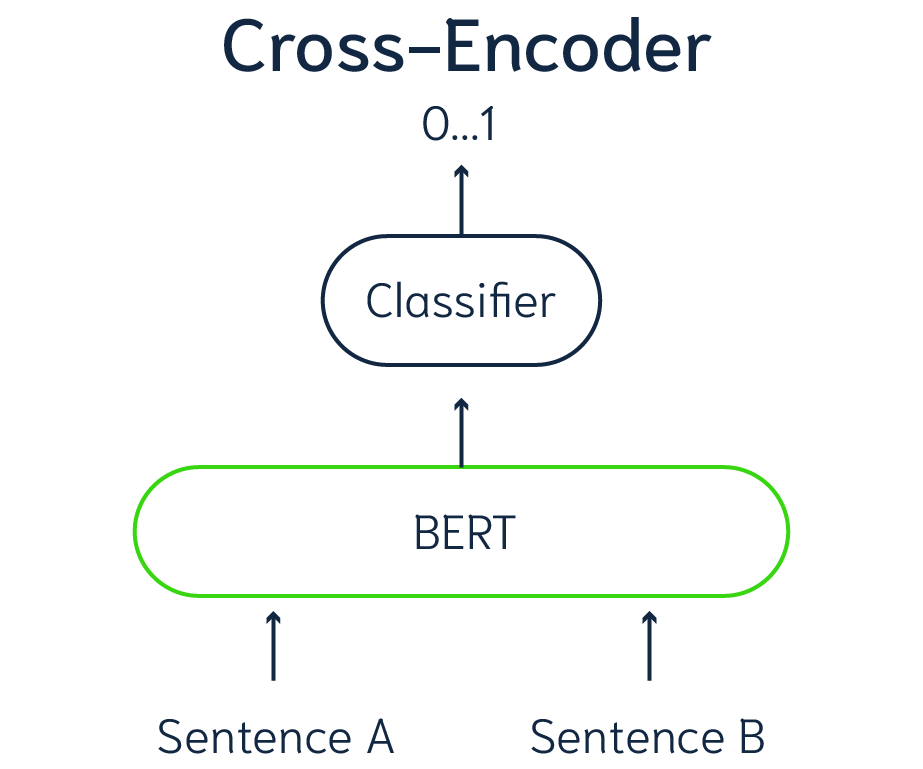

In [26]:
from langchain_community.cross_encoders import HuggingFaceCrossEncoder ## we need a cross encoder model
from langchain.retrievers.document_compressors import CrossEncoderReranker ## we need a reranker
from langchain.retrievers import ContextualCompressionRetriever ## context compression

## Retriever 1 - simple cosine distance BASE retriever technique
similarity_retriever = chroma_db3.as_retriever(search_type='similarity',
                                              search_kwargs={'k': 3})


## Load open-source reranker model -- `cross-encoder/qnli-electra-base` from huggingface
reranker = HuggingFaceCrossEncoder(model_name='cross-encoder/qnli-electra-base')
reranker_compressor = CrossEncoderReranker(model=reranker, top_n=2)

## Retriever 2 - Uses a Reranker model to rerank retrieval results from previous retriever #1
final_retriever = ContextualCompressionRetriever(
    base_compressor=reranker_compressor,
    base_retriever=similarity_retriever
)

config.json:   0%|          | 0.00/771 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/268 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [27]:
## now re-try query 1 with hybrid search/ensemble retriever
query = "What is the capital of India?"
docs = final_retriever.invoke(query)
docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.'),
 Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once 

In [28]:
## 2nd query with hybrid search/ensemble retriever
query = "What is the old capital of India?"
docs = final_retriever.invoke(query)
docs

[Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once the center of industry and education. However, it has witnessed political violence and economic problems since 1954. Since 2000, Kolkata has grown due to economic growth. Like other metropolitan cities in India, Kolkata struggles with poverty, pollution and traffic congestion."),
 Document(metadata={'article_id': '352194', 'title': 'Gandhinagar'}, page_content='Gandhinagar is the capital city of Gujarat state in India. It is 23\xa

Summary:
* We can immediately see the 1st query using the hybrid approach gives the correct answer as the 1st document which is New Delhi!
* The 2nd query also gave us the correct answer as the 1st document which is Kolkata.
* This does show the power of hybrid search and reranking so rather than just retrieving the documents we can put them in the order based on:
  * 1. Cosine similarity
  * 2. Relevancy
* The key here is that the cross encoder which reranks the documents gives us something the dense cosine sim search does not which is the power of NOT just cosine sim but showing us what we retrieved whether it is MORE relevant to the original query!
* **You can actually train and fine-tune your own cross encoder reranker using the SentenceTransformer library using your own data with question-answer pairs.**

# Exploring Contextual Compression Techniques

## LLM Prompt-based Contextual Compression Retrieval
* The contextual compression can happen in the form of:
  * Remove parts of content of retrieved docs which are NOT relevant to the query.
    * This is done by **extracting ONLY relevant parts** of the document to the given query.
  * Filter out docs which are NOT relevant to the given query **but DO NOT remove content from documents.**

* Below we will look closely at the `LLMChainExtractor` which will:
  * 1. Iterate over the initially returned documents and extract from each only the content that is relevant to the query.
  * 2. Totally IRRELEVANT docs might also be dropped.


### Note about BASE retrievers below
* You don't always have to use cosine similarity.
* You can use other retrievers we mentioned such as:
  * 1. Multi-query retriever
  * 2. Ensemble Retriever - hybrid
  * 3. Sparse Vector (e.g. BM25, SPLADE)
  

In [29]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_openai import ChatOpenAI

# init LLM we will use
chatgpt = ChatOpenAI(model_name='gpt-4o', temperature=0)

## setup BASE retrieval technique which is cosine similarity retriever with chroma_db
similarity_retriever = chroma_db3.as_retriever(search_type='similarity',
                                               search_kwargs={'k': 3})

# extracting from each document ONLY content that is relevant to query
compressor = LLMChainExtractor.from_llm(llm=chatgpt)

# retrieves docs similar to query and applies to compressor
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=similarity_retriever,
)

In [30]:
## lets try query 1 again
query = "What is the capital of India?"
docs = compression_retriever.invoke(query)
docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi.')]

Summary:
* We can see how powerful Contextual Compression is because it ONLY retrieves the relevant chunk or portion of the document to answer the query or question and NOT the entire document itself.

In [31]:
## lets try query 2
query = "What is the old capital of India?"
docs = compression_retriever.invoke(query)
docs

[Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content='Kolkata served as the capital of India during the British Raj until 1911.')]

Summary:
* Again we can see we have the correct answer with only the RELEVANT context in the answer.
* **While is is EFFECTIVE, sometimes it can be TOO AGGRESSIVE and remove contextual content that we do want to return to a user which is why it requires experimentation and using various models, retrievers, and parameters.**

### `LLMChainFilter`
* This is a bit simpler and more robust compressor than the previous one we just used.
* This uses an LLM chain to determine which of the initially retrieved documents to filter out and which ones to return, without manipulating the document contents.
* **This retriever DOES NOT remove the full document as the one before.**

In [32]:
from langchain.retrievers.document_compressors import LLMChainFilter

## setup BASE cosine sim retriever
similarity_retriever = chroma_db3.as_retriever(search_type='similarity',
                                               search_kwargs={'k': 3})

# decides which of initially retrieved documents to filter out and which ones to return
_filter = LLMChainFilter.from_llm(llm=chatgpt)

# retrieves docs similar to query and then applies filter
compression_retriever = ContextualCompressionRetriever(
    base_compressor=_filter,
    base_retriever=similarity_retriever
)

In [33]:
## trying query #1 again
query = "What is the capital of India?"
docs = compression_retriever.invoke(query)
docs

[Document(metadata={'article_id': '5117', 'title': 'New Delhi'}, page_content='New Delhi () is the capital of India and a union territory of the megacity of Delhi. It has a very old history and is home to several monuments where the city is expensive to live in. In traditional Indian geography it falls under the North Indian zone. The city has an area of about 42.7\xa0km. New Delhi has a population of about 9.4 Million people.')]

In [34]:
## trying query #1 again
query = "What is the old capital of India?"
docs = compression_retriever.invoke(query)
docs

[Document(metadata={'article_id': '4062', 'title': 'Kolkata'}, page_content="Kolkata (spelled Calcutta before 1 January 2001) is the capital city of the Indian state of West Bengal. It is the second largest city in India after Mumbai. It is on the east bank of the River Hooghly. When it is called Calcutta, it includes the suburbs. This makes it the third largest city of India. This also makes it the world's 8th largest metropolitan area as defined by the United Nations. Kolkata served as the capital of India during the British Raj until 1911. Kolkata was once the center of industry and education. However, it has witnessed political violence and economic problems since 1954. Since 2000, Kolkata has grown due to economic growth. Like other metropolitan cities in India, Kolkata struggles with poverty, pollution and traffic congestion.")]

Summary
* So we can see that using this type of retriever we can keep MOST of the document and remove the IRRELEVANT portions of the document and return more information than contextual compression alone.

# How to handle WRONG Format in RAG

## 1. Native LLM Output Response


In [35]:
from langchain_openai import ChatOpenAI


## init LLM --> we give the response format to the LLM which is JSON
chatgpt = ChatOpenAI(model_name="gpt-4o-mini", temperature=0,
                     model_kwargs={"response_format": {"type": "json_object"}})

In [36]:
## prompt
prompt = """Who won the Champions league in 2023,
            Output should be in JSON and have the following fields:
            win_team, lose_team, venue, date, score
          """

## response
response = chatgpt.invoke(prompt)

In [37]:
## print response
print(response.content)

{
  "win_team": "Manchester City",
  "lose_team": "Inter Milan",
  "venue": "Atatürk Olympic Stadium",
  "date": "June 10, 2023",
  "score": "1-0"
}


In [38]:
## check data type of response
type(response.content)

str

Summary
* Response output is still a string, we need to fix this, but how?

## 2. Output Parsers
* This is a very powerful technique to use for directing the correct output from the LLM.
* Pydantic gives us a lot of tools to do this.

In [41]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field ##pydantic lets us create a data class


# Define your desired data structure - like a python data class.
class GameDetails(BaseModel):
  ## Custom fields for structured output parser
    win_team: str = Field(description="The winning team in the football game")
    lose_team: str = Field(description="The losing team in the football game")
    venue: str = Field(description="The venue of the football game")
    date: str = Field(description="The date of the football game")
    score: str = Field(description="The score of the football game")


## init parser
parser = JsonOutputParser(pydantic_object=GameDetails)


In [42]:
## get output
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"win_team": {"description": "The winning team in the football game", "title": "Win Team", "type": "string"}, "lose_team": {"description": "The losing team in the football game", "title": "Lose Team", "type": "string"}, "venue": {"description": "The venue of the football game", "title": "Venue", "type": "string"}, "date": {"description": "The date of the football game", "title": "Date", "type": "string"}, "score": {"description": "The score of the football game", "title": "Score", "type": "string"}}, "required": ["win_team", "lo

### Now we create a prompt template

In [43]:
from langchain_core.prompts import PromptTemplate

## prompt
prompt_txt = """
             Who won the Champions league in 2023
             Use the following format when generating the output response

             Output format instructions:
             {format_instructions}`
             """

## prompt template
prompt = PromptTemplate.from_template(template=prompt_txt)


### Create LLM chain

In [44]:
## LLM chain using LCEL syntax
llm_chain = (prompt
              |
            chatgpt
              |
            parser)

## output response
response = llm_chain.invoke({"format_instructions": parser.get_format_instructions()})



In [45]:
## response
response

{'win_team': 'Manchester City',
 'lose_team': 'Inter Milan',
 'venue': 'Atatürk Olympic Stadium',
 'date': '2023-06-10',
 'score': '1-0'}

In [46]:
type(response)

dict

Summary
* We can see the response is a python dictionary thus we can automatically send this to a database or dataframe without having to convert the datatype as with the LLM prompting the output alone!